In [4]:
import os
from dotenv import load_dotenv

In [5]:
LUMA_API_KEY = os.getenv("LUMAAI_API_KEY")
PERPLEXITY_API_KEY = os.getenv("PERPLEXITY_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

#### OCR --> Extracting Text from Legacy 2D PDF Blueprints

In [6]:
# import fitz  # PyMuPDF
# import os

# # Path to test blueprints
# blueprint_folder = "tests/"
# blueprint_files = [
#     "blueprint_aircraft_panel.pdf",
#     "blueprint_compressor_blade.pdf",
#     "blueprint_turbine_rotor.pdf"
# ]

# # Extract text from PDFs using PyMuPDF
# for file in blueprint_files:
#     pdf_path = os.path.join(blueprint_folder, file)
#     doc = fitz.open(pdf_path)  # Open the PDF
    
#     extracted_text = []
#     for page in doc:
#         extracted_text.append(page.get_text("text"))  # Extract text from each page
    
#     extracted_text_str = "\n".join(extracted_text)
    
#     print(f"\n📜 Extracted text from {file}:\n{extracted_text_str}\n")

import fitz  # PyMuPDF for PDF text extraction
import requests
import json
import os

# ✅ Load API Key for Perplexity
PERPLEXITY_API_KEY = os.getenv("PERPLEXITY_API_KEY")
PERPLEXITY_API_URL = "https://api.perplexity.ai/chat/completions"

headers = {
    "Authorization": f"Bearer {PERPLEXITY_API_KEY}",
    "Content-Type": "application/json"
}

# ✅ Folder containing test blueprint PDFs
blueprint_folder = "tests/"
blueprint_files = [
    "blueprint_aircraft_panel.pdf",
    "blueprint_compressor_blade.pdf",
    "blueprint_turbine_rotor.pdf"
]

# ✅ Step 1: Extract text from PDFs
ocr_results = {}  # Store extracted text for each file

for file in blueprint_files:
    pdf_path = os.path.join(blueprint_folder, file)
    doc = fitz.open(pdf_path)  # Open the PDF
    
    extracted_text = []
    for page in doc:
        extracted_text.append(page.get_text("text"))  # Extract text from each page
    
    extracted_text_str = "\n".join(extracted_text)
    ocr_results[file] = extracted_text_str  # Store in dictionary


### Converting Extracted Text into Structured JSON Using Perplexity

the code below cuz perplexity returning yee-yee-ahh stuff and not just json bruh

In [7]:
import json
import re

def extract_json_from_response(response_text):
    """Extracts only the JSON block from Perplexity's response."""
    json_match = re.search(r"```json\n(.*?)\n```", response_text, re.DOTALL)
    if json_match:
        json_str = json_match.group(1)
        try:
            return json.loads(json_str)  # Convert to dictionary
        except json.JSONDecodeError as e:
            print("❌ JSON Parsing Error:", e)
            return None
    else:
        print("❌ No JSON block found in response!")
        return None


In [ ]:
import fitz  # PyMuPDF for PDF text extraction
import requests
import json
import os

# ✅ Load API Key for Perplexity
PERPLEXITY_API_KEY = os.getenv("PERPLEXITY_API_KEY")
PERPLEXITY_API_URL = "https://api.perplexity.ai/chat/completions"

headers = {
    "Authorization": f"Bearer {PERPLEXITY_API_KEY}",
    "Content-Type": "application/json"
}

# ✅ Folder containing test blueprint PDFs
blueprint_folder = "tests/"
blueprint_files = [
    "blueprint_aircraft_panel.pdf",
    "blueprint_compressor_blade.pdf",
    "blueprint_turbine_rotor.pdf"
]

# ✅ Step 1: Extract text from PDFs
ocr_results = {}  # Store extracted text for each file

for file in blueprint_files:
    pdf_path = os.path.join(blueprint_folder, file)
    doc = fitz.open(pdf_path)  # Open the PDF
    
    extracted_text = []
    for page in doc:
        extracted_text.append(page.get_text("text"))  # Extract text from each page
    
    extracted_text_str = "\n".join(extracted_text)
    ocr_results[file] = extracted_text_str  # Store in dictionary

# ✅ Step 2: Function to format extracted text using Perplexity AI
def format_text_with_perplexity(extracted_text):
    prompt = f"""
    Convert the following aerospace blueprint text into structured JSON format with these keys:
    - component_name
    - material
    - dimensions (length, width, height, tolerance if available)
    - engineering_notes (as a list)

    Ensure the output is **valid JSON** and does **not include explanations**. 

    ONLY return JSON. Do NOT include any introductory or explanatory text.

    Text:
    {extracted_text}
    """

    response = requests.post(
        PERPLEXITY_API_URL,
        json={"model": "sonar", "messages": [{"role": "user", "content": prompt}]},
        headers=headers
    )

    # 🔍 Debugging: Print API Response
    print("\n🔍 API Status Code:", response.status_code)
    print("\n🔍 API Response Text:", response.text)

    if response.status_code != 200:
        print("❌ API Error:", response.status_code, response.text)
        return None  # Stop processing if API call fails

    try:
        response_json = response.json()
        content = response_json["choices"][0]["message"]["content"]
        
        structured_data = extract_json_from_response(content)
        return structured_data  # Clean JSON output
    except json.JSONDecodeError as e:
        print("❌ JSON Parsing Error:", e)
        return None

# ✅ Step 3: Process each extracted text with Perplexity
formatted_data = {}

for file, text in ocr_results.items():
    structured_json = format_text_with_perplexity(text)
    if structured_json:  # Store only valid JSON responses
        formatted_data[file] = structured_json

# ✅ Step 4: Print final structured JSON
print(json.dumps(formatted_data, indent=4))


### OpenAI GPT-4 generates a perfect Sora prompt using the structured JSON data

In [ ]:
import openai
import json
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# ✅ Initialize OpenAI client (NEW WAY)
client = openai.OpenAI(api_key=OPENAI_API_KEY)

def generate_sora_prompt(blueprint_json):
    """Generates an optimized Sora prompt for blueprint visualization"""

    system_message = "You are an expert in MIL-STD-31000 aerospace engineering documentation. Generate a well-structured, precise prompt for a text-to-video AI model (Sora) to visualize the given aerospace blueprint in compliance with technical data package standards."

    user_prompt = f"""
    Given the following structured aerospace blueprint JSON, generate a **MIL-STD-31000-compliant** text prompt to be used in an AI text-to-video generation model.

    Ensure that:
    - The model follows **technical engineering visualization** standards.
    - The animation **adheres to correct proportions and dimensions**.
    - The **labeling and annotations** are clear and legible.
    - The **output resembles an aerospace CAD blueprint**, avoiding unnecessary artistic effects.

    Here is the blueprint JSON:
    {json.dumps(blueprint_json, indent=4)}

    Generate the **final prompt** in a **clean, structured format** with placeholders for different component types.
    """

    response = client.chat.completions.create(  # ✅ UPDATED METHOD
        model="gpt-4o",
        messages=[
            {"role": "system", "content": system_message},
            {"role": "user", "content": user_prompt}
        ],
        max_tokens=500
    )

    return response.choices[0].message.content  # ✅ UPDATED RESPONSE ACCESS

# ✅ Example Usage:
# Assuming `formatted_data` contains the structured JSON output from Perplexity
for file, blueprint in formatted_data.items():
    sora_prompt = generate_sora_prompt(blueprint)
    print(f"📜 **Generated Sora Prompt for {file}:**\n{sora_prompt}\n")

###  Feeding structured JSON into Luma AI’s Dream Machine API to generate 3D renders of the aerospace parts

In [10]:
import os
from lumaai import LumaAI

# Initialize Luma Client
client = LumaAI(auth_token=os.getenv("LUMAAI_API_KEY"))


### text to 2d image of legacy part

🎨 Generating Image... (Please wait)
🎨 Generating Image... (Please wait)
🎨 Generating Image... (Please wait)
🎨 Generating Image... (Please wait)
✅ Image Generated: https://storage.cdn-luma.com/dream_machine/86b60c76-0cf2-4379-9cd2-a46109998df8/2a22721b-cbfa-44fd-ab91-366588b9f8b9_resultd47cd3176b6adc59.jpg


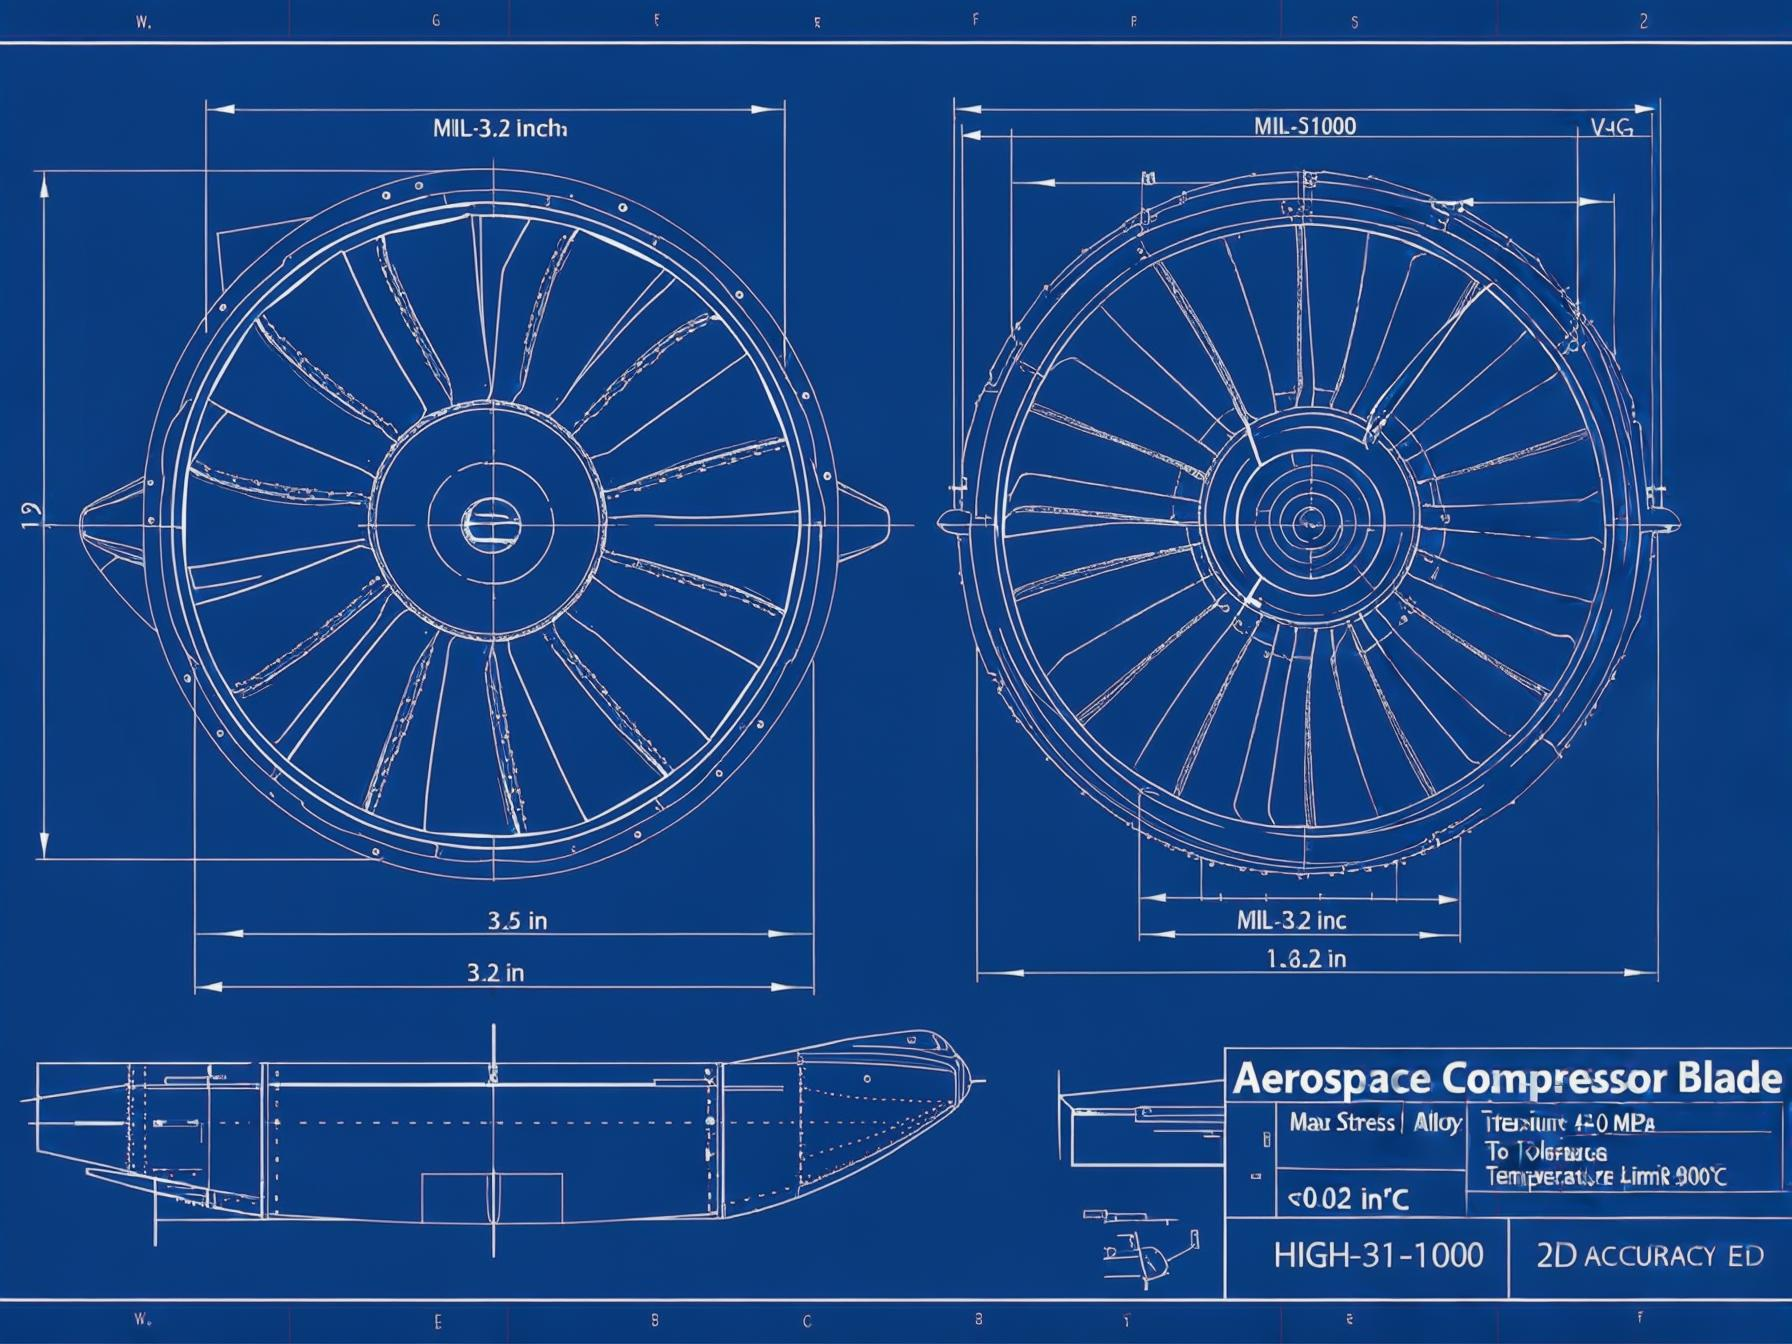

In [12]:
import requests
import time
import os
from lumaai import LumaAI
from IPython.display import display
from PIL import Image
from io import BytesIO

# ✅ Load API Key
LUMA_API_KEY = os.getenv("LUMAAI_API_KEY")

# ✅ Initialize Luma Client
client = LumaAI(auth_token=LUMA_API_KEY)

def generate_luma_image(prompt, aspect_ratio="4:3", model="photon-1"):
    """Generates a 2D engineering-style aerospace blueprint using Luma AI."""
    try:
        # ✅ Step 1: Request image generation
        generation = client.generations.image.create(
            prompt=prompt,
            aspect_ratio=aspect_ratio,  # ✅ 4:3 aspect ratio for technical documents
            model=model  # ✅ Use 'photon-1' for accurate blueprints
        )

        # ✅ Step 2: Poll until completion
        completed = False
        while not completed:
            generation = client.generations.get(id=generation.id)
            if generation.state == "completed":
                completed = True
            elif generation.state == "failed":
                raise RuntimeError(f"Generation failed: {generation.failure_reason}")
            print("🎨 Generating Image... (Please wait)")
            time.sleep(5)  # ✅ Wait before polling again

        # ✅ Step 3: Retrieve the final image URL
        image_url = generation.assets.image
        print(f"✅ Image Generated: {image_url}")

        # ✅ Step 4: Download & Display Image in Notebook
        response = requests.get(image_url, stream=True)
        img = Image.open(BytesIO(response.content))
        display(img)

        return image_url  # ✅ Return image URL for further use

    except Exception as e:
        print(f"❌ Error: {e}")
        return None

# ✅ Example: Generate a 2D Engineering Blueprint
prompt_text = """
Generate a **high-accuracy 2D technical blueprint** of an **Aerospace Compressor Blade** in **MIL-STD-31000 engineering format**.

**Technical Requirements:**
- **Monochrome CAD-style blueprint**, precise **engineering lines & dimensions**.
- Display **top, front, and side views** of the panel.
- Include key measurements:
Aerospace Legacy Blueprint - Compressor Blade
Technical Drawing (Scaled Representation)
Component Specifications
Part Name: Compressor Blade
Material: Titanium Alloy
Dimensions: Length: 12.5 in, Width: 3.2 in
Engineering Notes
- Max Stress: 450 MPa
- Tolerance: ±0.02 inches
- Temperature Limit: 900°C

The image should resemble a **Cold War-era aerospace blueprint**, adhering to **MIL-STD-31000 standards for defense applications**.

"""

# ✅ Call Luma AI to generate the image
luma_image_url = generate_luma_image(prompt_text)


In [ ]:
import requests
import time
import os
from lumaai import LumaAI

# Initialize Luma Client
client = LumaAI(auth_token=os.getenv("LUMAAI_API_KEY"))

# Function to generate a MIL-STD-31000-compliant 3D video
def generate_luma_video(prompt, aspect_ratio="4:3", model="ray-2"):
    """Sends a text prompt to Luma AI and generates a MIL-STD-31000 aerospace visualization"""
    try:
        generation = client.generations.video.create(
            prompt=prompt,
            aspect_ratio=aspect_ratio,  # 16:9 widescreen format
            model=model,  # Use Luma's ray-2 model for engineering render
        )

        # Polling for completion
        completed = False
        while not completed:
            generation = client.generations.get(id=generation.id)
            if generation.state == "completed":
                completed = True
            elif generation.state == "failed":
                raise RuntimeError(f"Generation failed: {generation.failure_reason}")
            print("🎥 Generating Video... (Please wait)")
            time.sleep(5)  # Wait before polling again

        # Get the final video URL
        video_url = generation.assets.video
        print(f"✅ Video Generated: {video_url}")

        # Download the video
        response = requests.get(video_url, stream=True)
        video_filename = f'{generation.id}.mp4'
        with open(video_filename, 'wb') as file:
            file.write(response.content)

        print(f"📂 Video saved as {video_filename}")

        return video_filename

    except Exception as e:
        print(f"❌ Error: {e}")
        return None

# ✅ Example: Generate MIL-STD-31000 Video
prompt_text = """
Generate a **cinematic-quality 3D rendering** of a **Titanium Alloy Compressor Blade** in a **high-fidelity aerospace-grade visualization**.

**Camera Movement:**
- Start with a **slow, dramatic zoom-in** towards the center of the compressor blade.
- Rotate **360 degrees** around the object to highlight its geometry.
- Show a **dynamic light sweep** to emphasize metallic reflections.

**Material & Texture:**
- Titanium alloy with **realistic metallic sheen and detailed micro-scratches**.
- Reflective surfaces should interact with **HDR light sources**.
- **Polished edges, smooth curvature, and ultra-precise machining details**.

**Environmental Setup:**
- Use **cinematic studio lighting** with **soft reflections and shadows**.
- Background should be **neutral dark grey with subtle diffusion**.
- **High-contrast rim lighting** for dramatic edges.

**Animation Style:**
- Frame rate: **Smooth 60 FPS rendering**.
- Precision-engineered **Mach 2-rated aerospace component**.
- **Slow-motion highlight** of surface imperfections and precision details.
- **Wireframe overlay for technical visualization** (optional).

Ensure the video follows a **realistic CGI pipeline** with **physics-based rendering (PBR materials)**.
"""


# Call Luma AI to generate the video
video_file = generate_luma_video(prompt_text)
